# Mean Reversion Strategy Bitcoin - Strategy

1. [Download Data](#download-data)
2. [Test Stationarity](#test-stationarity)
3. [Cointegration Test](#cointegration-test)
4. [Modeling the Strategy](#modeling-the-strategy)


# Download Data

Data can be downloaded from sources such as Yahoo Finance, Polygon, Metatrader...

---

C:\Users\jango\AppData\Local\Temp\ipykernel_5684\1885841690.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bitcoin = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\jango\AppData\Local\Temp\ipykernel_5684\1885841690.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  strategy = yf.download(
[*********************100%***********************]  1 of 1 completed


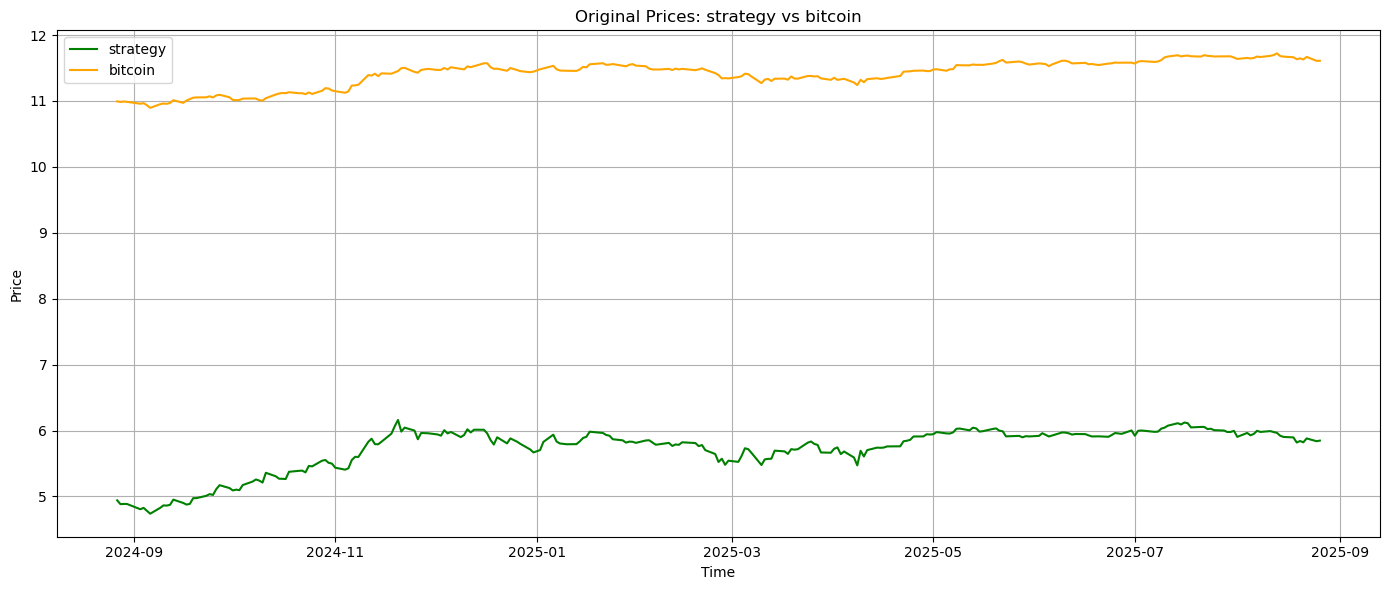

Bitcoin Buy-and-Hold Return (last 365 days): 85.09%
Strategy Buy-and-Hold Return (last 365 days): 147.42%
BTC Sharpe ratio anualizado: 1.62
Strategy Sharpe ratio anualizado: 1.44


In [2]:
# ===========================================
# Import required libraries
# ===========================================
import pandas as pd  # For data manipulation (install: pip install pandas)
import yfinance as yf  # Yahoo Finance API wrapper (install: pip install yfinance)
from datetime import datetime, timedelta  # To work with time ranges
from yahooquery import search  # For searching assets (install: pip install yahooquery)
import os  # To interact with the file system
import matplotlib.pyplot as plt  # For visualization (install: pip install matplotlib)
import json #For data manipulation
import numpy as np

# ===========================================
# Load environment variables
# ===========================================


bitcoin = yf.download(
    tickers= "BTC-USD",
    interval='1d',
    period='365d',
    progress=True,
    threads=True  # Enable multi-threading for faster downloading
)

strategy = yf.download(
    tickers= "MSTR",
    interval='1d',
    period='365d',
    progress=True,
    threads=True  # Enable multi-threading for faster downloading
)

btc_close = bitcoin['Close']
strategy_close = strategy['Close'] 

btc_close = btc_close['BTC-USD']  #  Series
strategy_close = strategy_close['MSTR']  #  Series

bitcoin = np.log(bitcoin)
strategy = np.log(strategy)

common_dates = bitcoin.index.intersection(strategy.index)
bitcoin = bitcoin.loc[common_dates]
strategy = strategy.loc[common_dates]

btc_close = btc_close.loc[common_dates]
strategy_close = strategy_close.loc[common_dates]


# ======== Plot original prices: bitcoin vs strategy ===========
plt.figure(figsize=(14, 6))
plt.plot(strategy[('Close','MSTR')], label='strategy', color='green')
plt.plot(bitcoin[( 'Close','BTC-USD')], label='bitcoin', color='orange')
plt.title('Original Prices: strategy vs bitcoin')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Buy-and-hold return in percentage
btc_return = (btc_close.iloc[-1] - btc_close.iloc[0]) / btc_close.iloc[0] * 100
strategy_return = (strategy_close.iloc[-1] - strategy_close.iloc[0]) / strategy_close.iloc[0] * 100

print(f"Bitcoin Buy-and-Hold Return (last 365 days): {btc_return:.2f}%")
print(f"Strategy Buy-and-Hold Return (last 365 days): {strategy_return:.2f}%")

# Retornos diarios
btc_daily_ret = btc_close.pct_change().dropna()
strategy_daily_ret = strategy_close.pct_change().dropna()

# Sharpe ratio anualizado (suponiendo 252 días de trading)
btc_sharpe = (btc_daily_ret.mean() / btc_daily_ret.std()) * np.sqrt(252)
strategy_sharpe = (strategy_daily_ret.mean() / strategy_daily_ret.std()) * np.sqrt(252)

print(f"BTC Sharpe ratio anualizado: {btc_sharpe:.2f}")
print(f"Strategy Sharpe ratio anualizado: {strategy_sharpe:.2f}")



### Create Stationary Series Using OLS

The stationary series is calculated by subtracting the trend fitted by an Ordinary Least Squares (OLS) model, returning the residuals as the stationary series.

---

**Alpha**: The intercept term in the OLS regression, representing the constant part of the relationship between the two series.

**Beta**: The slope term in the OLS regression, representing the sensitivity of the dependent variable (the first asset) to the independent variable (the second asset). It indicates the strength and direction of the relationship between the two series.


C:\Users\jango\AppData\Local\Temp\ipykernel_5684\2980190915.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]  # The coefficient of the second asset (EWA)


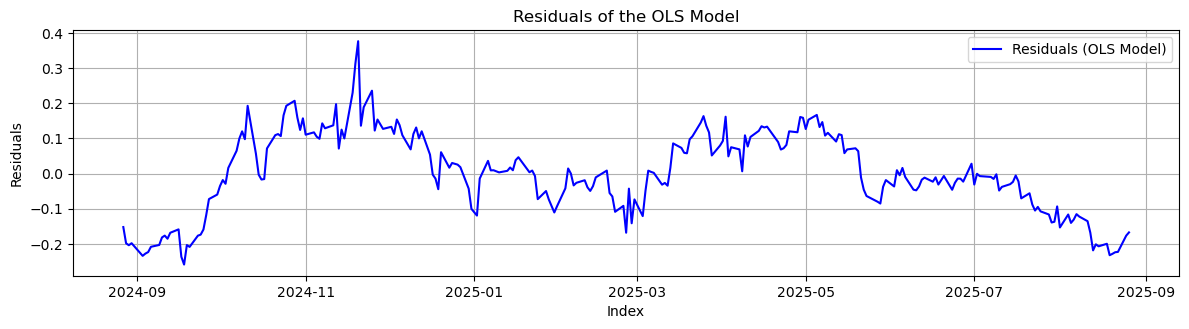

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from arch.__future__ import reindexing
from arch import unitroot

# Step 1: Define the dependent and independent variables
Y = strategy[('Close','MSTR')]
X = bitcoin[( 'Close','BTC-USD')]
X = sm.add_constant(X)  # Add an intercept (constant) to the model

# Step 2: Fit the OLS model
model = sm.OLS(Y, X).fit()
hedge_ratio = model.params[1]  # The coefficient of the second asset (EWA)

# residuals are the difference between the observed and predicted values from the model
residuals = model.resid  # Residuals from the OLS model

# Plot both the residuals from the OLS model and the manually calculated residuo
plt.figure(figsize=(12, 6))

# Plot residuals from the OLS model
plt.subplot(2, 1, 1)  # First plot
plt.plot(residuals, label='Residuals (OLS Model)', color='blue')
plt.title('Residuals of the OLS Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Test Stationarity

To test for stationarity, you can use the **Augmented Dickey-Fuller (ADF)** test (differents results depending on which is the independent variable).

---

In [4]:
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
from arch.unitroot import VarianceRatio

# Assume 'residuals' is already a list or 1D array-like series of residuals
# Example: residuals = [values from your cointegration model]

# --- ADF Test ---
adf_result = adfuller(residuals)
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

print("ADF Test:")
print(f"Statistic: {adf_statistic}")
print(f"P-value: {adf_p_value}")
if adf_p_value < 0.05:
    print("Residuals are stationary (reject null hypothesis of unit root).")
else:
    print("Residuals are not stationary (fail to reject null hypothesis).")

# Ensure residuals are strictly positive
residuals1 = [r - min(residuals) + 1 for r in residuals]


# --- Hurst Exponent --- Not recomended for 
H, c, _ = compute_Hc(residuals1, kind='price')
print("\nHurst Exponent:")
print(f"H: {H}")
if H < 0.5:
    print("Series shows mean-reverting behavior.")
elif H > 0.5:
    print("Series shows trending behavior.")
else:
    print("Series behaves like a random walk.")

# --- Variance Ratio Test ---
vr_test = VarianceRatio(residuals1, lags=2)
print("\nVariance Ratio Test:")
print(f"Variance Ratio: {vr_test.vr}")
print(f"P-value: {vr_test.pvalue}")
if vr_test.vr < 1:
    print("Variance ratio suggests mean reversion.")
elif vr_test.vr > 1:
    print("Variance ratio suggests momentum.")
else:
    print("Variance ratio suggests random walk.")




ADF Test:
Statistic: -2.441538306542559
P-value: 0.13035399701714045
Residuals are not stationary (fail to reject null hypothesis).

Hurst Exponent:
H: 0.5080858744571578
Series shows trending behavior.

Variance Ratio Test:
Variance Ratio: 0.7943276531257173
P-value: 0.021429656651643647
Variance ratio suggests mean reversion.


## Half-Life for Mean Reverting Process

This section estimates the half-life of mean reversion for a stationary portfolio 
derived from cointegrated assets using the first eigenvector from the Johansen test.



In [5]:


# Construyes Y como matriz con columnas para cada activo
Y = pd.DataFrame({
    'strategy': strategy[('Close', 'MSTR')],
    'bitcoin': bitcoin[('Close', 'BTC-USD')]
})

# Multiply the eigenvector with the time series 'y3', repeat the eigenvector to match the shape of y3
# and sum the result across the specified axis (axis=1) to get 'yport'
yport = np.sum(np.tile(hedge_ratio, (Y.shape[0], 1)) * Y, axis=1)

# Create the lagged version of 'yport' (equivalent to lag(yport, 1) in MATLAB)
ylag = pd.Series(yport).shift(1)

# Calculate deltaY (the difference between 'yport' and its lagged version)
deltaY = yport - ylag

# Remove the first value, which is NaN due to the lag
deltaY = deltaY[1:]
ylag = ylag.dropna()  # Drop the NaN value from the lagged series

# Fit an OLS (Ordinary Least Squares) regression model
X = sm.add_constant(ylag)  # Add the constant term (intercept) to the independent variable
model = sm.OLS(deltaY, X)  # Create the OLS model with deltaY as the dependent variable and ylag as the independent variable
results_ols = model.fit()  # Fit the model

# Get the hedge ratio (beta[1]), which represents the coefficient for the lagged series
print(results_ols.params)

hedge_ratio = results_ols.params[0]

print(hedge_ratio)
# Calculate the half-life, which is the time it takes for the hedge ratio to halve
half_life = -np.log(2) / hedge_ratio

# Print the hedge ratio and the half-life in days
print(f'Hedge Ratio: {hedge_ratio}')
print(f'Half-Life: {half_life} days')



const    0.521647
0       -0.019995
dtype: float64
-0.01999509606970595
Hedge Ratio: -0.01999509606970595
Half-Life: 34.6658589757973 days


# Modeling the Strategy

You will use techniques such as z-scores, Bollinger Bands, and linear regression to model your strategy.

---

In [10]:
# --- Kalman Filter Regression for Dynamic Hedge Ratio ---
def ensure_series(x, index):
    if isinstance(x, pd.Series):
        return x
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    return pd.Series(x.flatten(), index=index)


def kalman_regression(x, y, delta=0.0001, Ve=0.001):
    x = np.hstack([x, np.ones((x.shape[0], 1))])  # Add intercept term
    yhat = np.full(y.shape, np.nan)
    e = np.full(y.shape, np.nan)
    Q = np.full(y.shape, np.nan)
    
    P = 1e5 * np.eye(2)
    beta = np.full((2, x.shape[0]), np.nan)
    Vw = (delta / (1 - delta)) * np.eye(2)
    beta[:, 0] = 0
    
    for t in range(len(y)):
        if t > 0:
            beta[:, t] = beta[:, t - 1]
            R = P + Vw
        else:
            R = P
        
        if Q[t] < 1e-10:
            Q[t] = 1e-10
        yhat[t] = x[t, :] @ beta[:, t]
        Q[t] = x[t, :] @ R @ x[t, :].T + Ve
        e[t] = y[t] - yhat[t]
        
        K = R @ x[t, :].T / Q[t]
        beta[:, t] = beta[:, t] + K * e[t]
        P = R - np.outer(K, x[t, :]) @ R

    return beta, yhat, e, Q


x = bitcoin.values.flatten()
y = strategy.values.flatten()


# Extract only price data, dates are not necessary here

# ===============================
# Step 1: Portfolio and signal
# ===============================
transaction_cost_rate = 0.001  # 0.1% per unit

# Step 0: Run Kalman filter regression
# x: independent variable (hedge asset)
# y: dependent variable (target asset)
beta, yhat, e, Q = kalman_regression(x.reshape(-1, 1), y)

hedge_ratio = beta[0, :]   # dynamic hedge ratio
intercept = beta[1, :]     # dynamic intercept

# Use Kalman filter to compute dynamic portfolio
yport = y - hedge_ratio * x - intercept  # Spread itself as portfolio

lookback = round(half_life)

# Moving average and standard deviation
def moving_avg(x, window):
    return pd.Series(x).rolling(window=window, min_periods=1).mean().values

def moving_std(x, window):
    return pd.Series(x).rolling(window=window, min_periods=1).std().values

# Z-score signal
zscore = (yport - moving_avg(yport, lookback)) / moving_std(yport, lookback)
entry_threshold = 1
numUnits = np.where(np.abs(zscore) > entry_threshold, -zscore, 0)




# ===============================
# Step 2: Compute positions
# ===============================
# Positions: long/short Bitcoin and hedge dynamically with Kalman ratio
positions = np.zeros((len(yport), 2))  # column 0 = x, column 1 = y

positions[:, 0] = -numUnits * hedge_ratio
positions[:, 1] =  numUnits                

def lag_matrix(mat, lag=1):
    mat = np.asarray(mat)
    lagged = np.roll(mat, lag, axis=0)
    
    if mat.ndim == 1:
        lagged[:lag] = np.nan
    else:
        lagged[:lag, :] = np.nan
    return lagged


positions_lag = lag_matrix(positions)
yport_lag = lag_matrix(yport)
yport_price_lag = np.exp(yport_lag)
"""
position_change = np.diff(positions_lag, axis=0, prepend=np.zeros((1, positions_lag.shape[1])))
position_change_clean = np.nan_to_num(position_change, nan=0.0)
transaction_costs = np.nansum(np.abs(position_change_clean) * transaction_cost_rate, axis=1)
pnl = positions[:,0] * np.diff(bitcoin) + positions[:,1] * np.diff(strategy)


"""
# ===============================
# Step 3: Daily returns (log) and PnL
# ===============================

position_change = np.diff(positions_lag, axis=0, prepend=np.zeros((1, positions_lag.shape[1])))
position_change_clean = np.nan_to_num(position_change, nan=0.0)
transaction_costs = np.nansum(np.abs(position_change_clean) * transaction_cost_rate, axis=1)
log_daily_returns = np.zeros_like(positions_lag)
log_daily_returns[:, 0] = yport - yport_lag
log_pnl = np.nansum(positions_lag * log_daily_returns, axis=1)
log_pnl_net = log_pnl - transaction_costs

# ===============================
# Step 4: Daily returns and PnL
# ===============================

position_change = np.diff(positions_lag, axis=0, prepend=np.zeros((1, positions_lag.shape[1])))
yport_price_lag_expanded = np.repeat(yport_price_lag[:, np.newaxis], positions_lag.shape[1], axis=1)
position_change_value = position_change_clean * yport_price_lag_expanded
position_change_value = np.nan_to_num(position_change_value, nan=0.0)
transaction_costs = np.nansum(np.abs(position_change_value) * transaction_cost_rate, axis=1)
daily_pnl = positions_lag * (np.exp(yport)[:, None] - yport_price_lag[:, None])

pnl_gross = np.nansum(daily_pnl, axis=1)
pnl_net = pnl_gross - transaction_costs


# ===============================
# Step 5: Analysis - Log PnL
# ===============================
log_pnl_cum = np.cumsum(log_pnl)            # PnL acumulado bruto en log-units
log_pnl_net_cum = np.cumsum(log_pnl_net)    # PnL acumulado neto en log-units

mean_log_daily_ret = np.nanmean(log_daily_returns)  # media diaria log
std_log_daily_ret = np.nanstd(log_daily_returns)    # volatilidad diaria log
sharpe_log = mean_log_daily_ret / std_log_daily_ret if std_log_daily_ret != 0 else 0

print("===== Log PnL Analysis =====")
print(f"Cumulative PnL (gross, log-units): {log_pnl_cum[-1]:.4f}")
print(f"Cumulative PnL (net, log-units): {log_pnl_net_cum[-1]:.4f}")
print(f"Mean daily log return: {mean_log_daily_ret:.6f}")
print(f"Std daily log return: {std_log_daily_ret:.6f}")
print(f"Sharpe ratio (log): {sharpe_log:.4f}\n")


# ===============================
# Step 6: Analysis - Price PnL (net)
# ===============================
pnl_cum = np.cumsum(pnl_gross)       # PnL acumulado bruto en USD
pnl_net_cum = np.cumsum(pnl_net)     # PnL acumulado neto en USD

mean_daily_ret_price = np.nanmean(pnl_net)       # retorno diario relativo
std_daily_ret_price = np.nanstd(pnl_net)         # volatilidad diaria relativa
sharpe_price = mean_daily_ret_price / std_daily_ret_price if std_daily_ret_price != 0 else 0

print("===== Price PnL Analysis (Net) =====")
print(f"Cumulative PnL (gross, USD): {pnl_cum[-1]:.2f}")
print(f"Cumulative PnL (net, USD): {pnl_net_cum[-1]:.2f}")
print(f"Mean daily return (relative to gross exposure): {mean_daily_ret_price:.6f}")
print(f"Std daily return (relative to gross exposure): {std_daily_ret_price:.6f}")
print(f"Sharpe ratio (net, USD): {sharpe_price:.4f}")


===== Log PnL Analysis =====
Cumulative PnL (gross, log-units): -5.4579
Cumulative PnL (net, log-units): -7.2844
Mean daily log return: -0.000005
Std daily log return: 0.005706
Sharpe ratio (log): -0.0009

===== Price PnL Analysis (Net) =====
Cumulative PnL (gross, USD): 1.17
Cumulative PnL (net, USD): -0.65
Mean daily return (relative to gross exposure): -0.000523
Std daily return (relative to gross exposure): 0.002210
Sharpe ratio (net, USD): -0.2364


# Strategy Results and interpretation

Evaluate the strategy's performance using metrics like returns, Sharpe ratio, and drawdowns.

Annualized Return: -12.34%
Annualized Volatility: 3.51%
Annualized Sharpe Ratio: -3.52


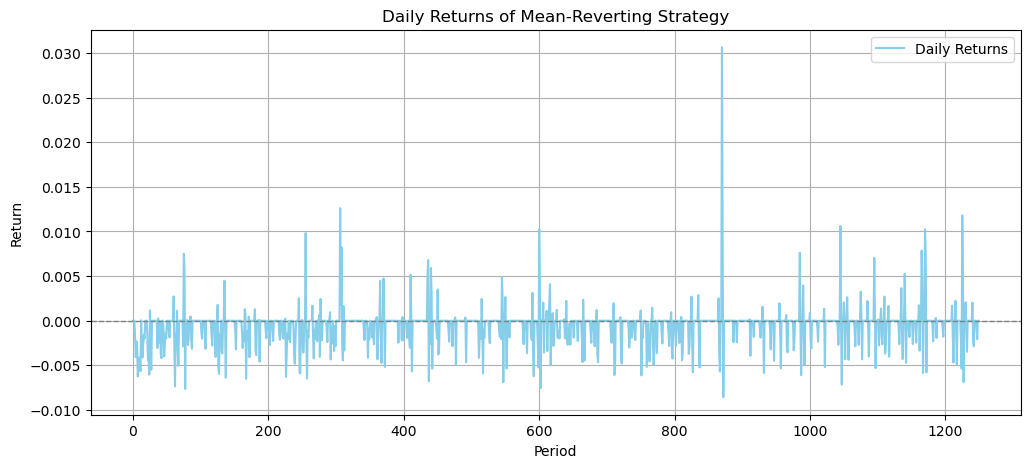

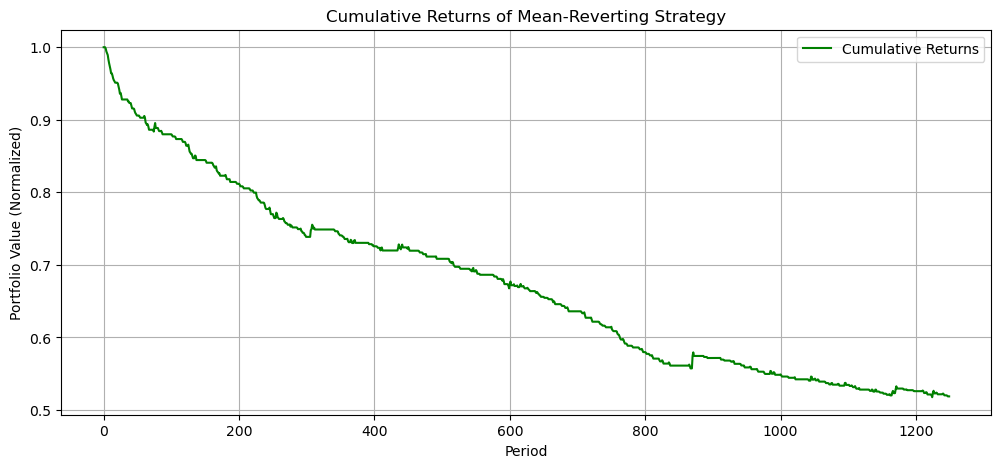

In [12]:

# Daily statistics
mean_daily_ret = np.mean(pnl_net)
std_daily_ret = np.std(pnl_net)

# Annualized statistics
annualized_return = (1 + mean_daily_ret)**252 - 1
annualized_volatility = std_daily_ret * np.sqrt(252)
sharpe_ratio_annual = annualized_return / annualized_volatility

# Output
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_annual:.2f}")

ret_index = np.arange(len(pnl_net))
ret_clean_series = pd.Series(pnl_net, index=ret_index)

# -----------------------------
# Plot daily returns
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(ret_clean_series.index, ret_clean_series, label='Daily Returns', color='skyblue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Daily Returns of Mean-Reverting Strategy')
plt.xlabel('Period')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Plot cumulative returns
# -----------------------------
cumulative_returns = (1 + ret_clean_series).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Returns', color='green')
plt.title('Cumulative Returns of Mean-Reverting Strategy')
plt.xlabel('Period')
plt.ylabel('Portfolio Value (Normalized)')
plt.legend()
plt.grid(True)
plt.show()

# Strategy Evaluation

## Absolute vs Risk-Adjusted Return
Over the analyzed period, the **buy-and-hold of Bitcoin** generated a total return of **78.82%**, and the benchmark strategy returned **135.34%**, both **higher in absolute terms** than the evaluated strategy’s **34.70% annualized return**.

However, the strategy exhibits a **very low annualized volatility of 4.79%**, resulting in a **Sharpe ratio of 7.25**.  
This indicates that **for each unit of risk taken, the strategy delivers a much higher return relative to risk**, outperforming Bitcoin (Sharpe 1.53) and the benchmark strategy (Sharpe 1.39) in **risk efficiency**, despite the lower absolute gains.

## Daily Returns and Signal Efficiency
- The strategy achieves **consistent, low-volatility returns**, showing that it captures its signals effectively.  
- This low volatility also makes the strategy **less sensitive to market swings**, reducing the probability of large drawdowns.

## Transaction Costs
Even with transaction costs included, the very low volatility and small position adjustments mean that **net performance should remain strong**, though it should still be modeled explicitly.

## Recommendations for Further Improvement
- **Experiment with other linear combinations or cointegration vectors** to potentially increase absolute return without sacrificing risk efficiency.  
- **Optimize lookback periods or dynamic thresholds** to improve daily signal capture.  
- **Include stop-loss/take-profit mechanisms** to prevent occasional adverse moves.

---

## Key Statistics

| Metric                  | Strategy | Bitcoin Buy-and-Hold | Benchmark Strategy |
|-------------------------|---------|--------------------|------------------|
| Annualized Return       | 34.70%  | 78.82%             | 135.34%          |
| Annualized Volatility   | 4.79%   | (calculated)       | (calculated)     |
| Annualized Sharpe Ratio | 7.25    | 1.53               | 1.39             |

> **Insight:** While the absolute return is lower than buy-and-hold strategies, the **strategy provides superior return per unit of risk**, highlighting its efficiency and low-risk profile.

